# Where are best locations for opening a new independent yarn shop?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import geopandas as gpd

%matplotlib inline

In [2]:
# read in shops_by_county dataframe
# sames solution as below with population csv to keep leading 0 in GEOID, state, and county and columns
shops_df = pd.read_csv('../data/df_shops_by_county.csv', dtype = {'STATEFP' : str,
                                                                  'COUNTYFP' : str,
                                                                  'GEOID' : str})
shops_df.head(2)


,address,city,id,latitude,location,longitude,name,pos_online,ravelry_retailer,shop_email,zip,country,state,geometry,index_right,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME
0,817B Regal Drive,Huntsville,9966,34.7091,"817B Regal Drive, Huntsville, Alabama",-86.5875,Fiber Art Work,True,True,fiberartwork@gmail.com,35801,United States,Alabama,POINT (-86.58750000000001 34.7091),2123,01,089,161570,01089,Madison
1,105 D Church Street,Madison,12262,34.6946,"105 D Church Street, Madison, Alabama",-86.7487,Hook A Frog Fiber & Fun,True,False,hookafrog@gmail.com,35758,United States,Alabama,POINT (-86.7487 34.6946),2123,01,089,161570,01089,Madison


In [3]:
shop_county_count_df = shops_df[['state', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME']].copy()
shop_county_count_df.head(2)

,state,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME
0,Alabama,01,089,161570,01089,Madison
1,Alabama,01,089,161570,01089,Madison


In [4]:
shop_count = shop_county_count_df.groupby('GEOID').count()
shop_count

,state,STATEFP,COUNTYFP,COUNTYNS,NAME
GEOID,,,,,
01003,1,1,1,1,1
01015,1,1,1,1,1
01055,1,1,1,1,1
01073,2,2,2,2,2
01079,1,1,1,1,1
...,...,...,...,...,...
56023,1,1,1,1,1
56025,2,2,2,2,2
56029,2,2,2,2,2


In [5]:
shop_county_count_df.drop_duplicates()

,state,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME
0,Alabama,01,089,161570,01089,Madison
4,Alabama,01,133,161592,01133,Winston
5,Alabama,01,079,161565,01079,Lawrence
6,Alabama,01,073,161562,01073,Jefferson
8,Alabama,01,097,161575,01097,Mobile
...,...,...,...,...,...,...
2088,Wyoming,56,039,1605083,56039,Teton
2089,Wyoming,56,013,1605072,56013,Fremont
2090,Wyoming,56,007,1605069,56007,Carbon
2091,Wyoming,56,033,1605081,56033,Sheridan


In [6]:
shop_count = shop_count.drop(['state', 'STATEFP', 'COUNTYFP', 'COUNTYNS'], 1)
shop_count

,NAME
GEOID,
01003,1
01015,1
01055,1
01073,2
01079,1
...,...
56023,1
56025,2
56029,2


In [7]:
shop_count = shop_count.reset_index()

In [8]:
shop_count = shop_count.rename(columns = {'NAME' : 'count'})
shop_count

,GEOID,count
0,01003,1
1,01015,1
2,01055,1
3,01073,2
4,01079,1
...,...,...
932,56023,1
933,56025,2
934,56029,2
935,56033,1


In [9]:
shop_count.loc[shop_count['GEOID'] == '01089']

,GEOID,count
5,01089,4


In [10]:
shop_county_count_df = shop_county_count_df.merge(shop_count, left_on = 'GEOID', right_on = 'GEOID').drop_duplicates()
shop_county_count_df

,state,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,count
0,Alabama,01,089,161570,01089,Madison,4
4,Alabama,01,133,161592,01133,Winston,1
5,Alabama,01,079,161565,01079,Lawrence,1
6,Alabama,01,073,161562,01073,Jefferson,2
8,Alabama,01,097,161575,01097,Mobile,1
...,...,...,...,...,...,...,...
2088,Wyoming,56,039,1605083,56039,Teton,1
2089,Wyoming,56,013,1605072,56013,Fremont,1
2090,Wyoming,56,007,1605069,56007,Carbon,1
2091,Wyoming,56,033,1605081,56033,Sheridan,1


In [11]:
# read in county population dataframe
# original file was in a different encoding, changed because I hoped using the standard encoding would 
# prevent leading 0 from being dropped in county column
# I need to concatenate those columns down the line to merge with shapefile (matches GEOID)
# easier to change read in to keep leading 0

pd.set_option('display.max_columns', 60)
population_df = pd.read_csv('../data/us_popest_2019_utf8.csv', dtype = {'STATE' : str,
                                                                        'COUNTY' : str})
population_df.head(2)


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019,BIRTHS2010,...,RNATURALINC2017,RNATURALINC2018,RNATURALINC2019,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RINTERNATIONALMIG2019,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,01,000,Alabama,Alabama,4779736,4780125,4785437,4799069,4815588,4830081,4841799,4852347,4863525,4874486,4887681,4903185,5312,13632,16519,14493,11718,10548,11178,10961,13195,15504,14226,...,1.184225,0.943643,0.701470,0.973446,1.210028,1.046273,0.761796,0.944900,1.189188,0.618401,0.692264,0.566242,-0.395013,-0.023714,0.476276,-0.198307,-0.318543,-0.444016,0.471965,1.081522,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,01,001,Alabama,Autauga County,54571,54597,54773,55227,54954,54727,54893,54864,55243,55390,55533,55869,176,454,-273,-227,166,-29,379,147,143,336,150,...,1.862012,2.037449,1.490099,0.072727,-0.254127,0.218816,0.127714,0.236887,-0.054492,-0.216933,-0.126214,-0.287248,5.945455,-5.971992,-4.121042,1.842729,-1.949762,4.831664,1.066590,0.667129,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062


In [12]:
population_df = population_df[['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME',
                               'CTYNAME', 'POPESTIMATE2019']].copy()
population_df.head(2)

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019
0,40,3,6,01,000,Alabama,Alabama,4903185
1,50,3,6,01,001,Alabama,Autauga County,55869


In [13]:
population_df.loc[population_df['COUNTY'] == '000']

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019
0,40,3,6,01,000,Alabama,Alabama,4903185
68,40,4,9,02,000,Alaska,Alaska,731545
98,40,4,8,04,000,Arizona,Arizona,7278717
114,40,3,7,05,000,Arkansas,Arkansas,3017804
190,40,4,9,06,000,California,California,39512223
249,40,4,8,08,000,Colorado,Colorado,5758736
314,40,1,1,09,000,Connecticut,Connecticut,3565287
323,40,3,5,10,000,Delaware,Delaware,973764
327,40,3,5,11,000,District of Columbia,District of Columbia,705749
329,40,3,5,12,000,Florida,Florida,21477737


In [14]:
# filter out state population rows (0 on the COUNTY column)

state_pop = population_df.loc[population_df['COUNTY'] == '000'].index
pop_county_df = population_df.drop(state_pop)
pop_county_df.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019
1,50,3,6,01,001,Alabama,Autauga County,55869
2,50,3,6,01,003,Alabama,Baldwin County,223234
3,50,3,6,01,005,Alabama,Barbour County,24686
4,50,3,6,01,007,Alabama,Bibb County,22394
5,50,3,6,01,009,Alabama,Blount County,57826


In [15]:
pop_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 1 to 3192
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SUMLEV           3142 non-null   int64 
 1   REGION           3142 non-null   int64 
 2   DIVISION         3142 non-null   int64 
 3   STATE            3142 non-null   object
 4   COUNTY           3142 non-null   object
 5   STNAME           3142 non-null   object
 6   CTYNAME          3142 non-null   object
 7   POPESTIMATE2019  3142 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 220.9+ KB


In [16]:
pop_county_df.loc[pop_county_df['STNAME'] == 'Alabama']

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019
1,50,3,6,01,001,Alabama,Autauga County,55869
2,50,3,6,01,003,Alabama,Baldwin County,223234
3,50,3,6,01,005,Alabama,Barbour County,24686
4,50,3,6,01,007,Alabama,Bibb County,22394
5,50,3,6,01,009,Alabama,Blount County,57826
...,...,...,...,...,...,...,...,...
63,50,3,6,01,125,Alabama,Tuscaloosa County,209355
64,50,3,6,01,127,Alabama,Walker County,63521
65,50,3,6,01,129,Alabama,Washington County,16326
66,50,3,6,01,131,Alabama,Wilcox County,10373


In [17]:
popcounty_merge_df = pd.merge(pop_county_df, shop_county_count_df,
                              how = 'left', 
                              left_on = ['STATE', 'COUNTY', 'STNAME'],
                              right_on = ['STATEFP', 'COUNTYFP', 'state'])
popcounty_merge_df.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,state,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,count
0,50,3,6,01,001,Alabama,Autauga County,55869,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50,3,6,01,003,Alabama,Baldwin County,223234,Alabama,01,003,161527.0,01003,Baldwin,1.0
2,50,3,6,01,005,Alabama,Barbour County,24686,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50,3,6,01,007,Alabama,Bibb County,22394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50,3,6,01,009,Alabama,Blount County,57826,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
popcounty_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SUMLEV           3142 non-null   int64  
 1   REGION           3142 non-null   int64  
 2   DIVISION         3142 non-null   int64  
 3   STATE            3142 non-null   object 
 4   COUNTY           3142 non-null   object 
 5   STNAME           3142 non-null   object 
 6   CTYNAME          3142 non-null   object 
 7   POPESTIMATE2019  3142 non-null   int64  
 8   state            935 non-null    object 
 9   STATEFP          935 non-null    object 
 10  COUNTYFP         935 non-null    object 
 11  COUNTYNS         935 non-null    float64
 12  GEOID            935 non-null    object 
 13  NAME             935 non-null    object 
 14  count            935 non-null    float64
dtypes: float64(2), int64(4), object(9)
memory usage: 392.8+ KB


In [19]:
# population per current shop
popcounty_merge_df['shop_pop'] = popcounty_merge_df['POPESTIMATE2019']/popcounty_merge_df['count']

In [20]:
# determine median, mean of population per current shop
popcounty_merge_df['shop_pop'].describe()


count    9.350000e+02
mean     1.141100e+05
std      1.688900e+05
min      5.915000e+02
25%      2.519150e+04
50%      5.436600e+04
75%      1.344078e+05
max      2.253858e+06
Name: shop_pop, dtype: float64

shop population
- count    935
- mean     114110
- std      168890
- min      591
- 25%      25191
- 50%      54366
- 75%      134407
- max      2,253,858

Median seems a reasonable measure of population likely to support a shop, although it is definitely not the whole picture. For my analysis this is a good place to start.

In [21]:
# replace null in shop_pop with current population
popcounty_merge_df['shop_pop'] = popcounty_merge_df['shop_pop'].fillna(popcounty_merge_df.POPESTIMATE2019)

In [22]:
# population available to support another shop, assuming median population required
popcounty_merge_df['avail_pop'] = popcounty_merge_df['POPESTIMATE2019']-(popcounty_merge_df['count']*54366)

In [23]:
# replace null in avail_pop with current population
popcounty_merge_df['avail_pop'] = popcounty_merge_df['avail_pop'].fillna(popcounty_merge_df.POPESTIMATE2019)

In [24]:
# number of shops available population could support assuming the median population required
popcounty_merge_df['shop_potential'] = popcounty_merge_df['avail_pop']/54366

In [25]:
# concat state and county columns to create geoid for every county, then drop original geoid column

popcounty_merge_df['geoid'] = popcounty_merge_df['STATE'] + popcounty_merge_df['COUNTY']
popcounty_merge_df = popcounty_merge_df.drop(['state', 'STATEFP', 'COUNTYFP', 'COUNTYNS',
                                              'GEOID', 'NAME'], axis = 1)

In [26]:
popcounty_merge_df.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,count,shop_pop,avail_pop,shop_potential,geoid
0,50,3,6,01,001,Alabama,Autauga County,55869,NaN,55869.0,55869.0,1.027646,01001
1,50,3,6,01,003,Alabama,Baldwin County,223234,1.0,223234.0,168868.0,3.106133,01003
2,50,3,6,01,005,Alabama,Barbour County,24686,NaN,24686.0,24686.0,0.454071,01005
3,50,3,6,01,007,Alabama,Bibb County,22394,NaN,22394.0,22394.0,0.411912,01007
4,50,3,6,01,009,Alabama,Blount County,57826,NaN,57826.0,57826.0,1.063643,01009


In [27]:
# ready for shape file and mapping
# chloropleth is appropriate here

In [28]:
# read in geojson county shapefile

counties = gpd.read_file('../data/tl_2017_us_county.json')
print(counties.crs)
counties.head(2)

epsg:4326


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,,,,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-97.01936 42.09058, -97.01933 42.089..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,,,,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.72832 46.26454, -123.72281 46.2..."


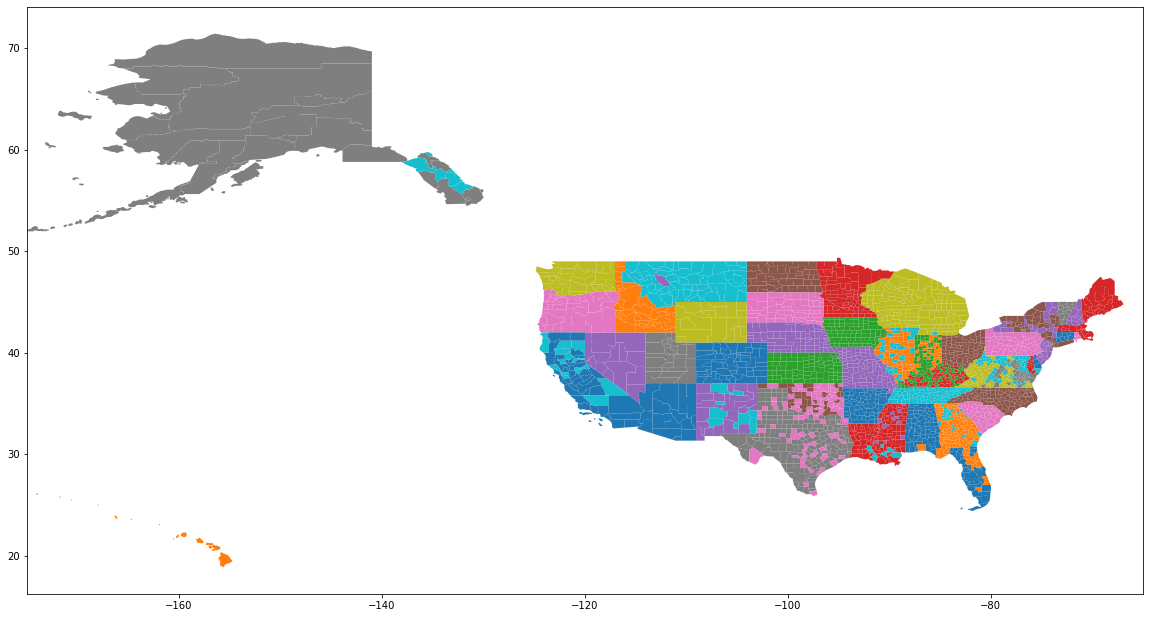

In [29]:
#take FIPS for territories and drop based on STATEFP column
territories_list = ['60', '66', '69', '72', '78']

counties = counties[~counties['STATEFP'].isin(territories_list)]

fig, ax = plt.subplots(figsize = (20, 20))

counties.plot(column = 'COUNTYNS', ax = ax)

# to tighten the map
plt.xlim(-175, -65);


In [30]:
# drop extra columns
counties = counties[['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'geometry']]
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,geometry
0,31,039,00835841,31039,Cuming,"POLYGON ((-97.01936 42.09058, -97.01933 42.089..."
1,53,069,01513275,53069,Wahkiakum,"POLYGON ((-123.72832 46.26454, -123.72281 46.2..."
2,35,011,00933054,35011,De Baca,"POLYGON ((-104.89338 34.08841, -104.89305 34.0..."
3,31,109,00835876,31109,Lancaster,"POLYGON ((-96.91094 41.04612, -96.91092 41.044..."
4,31,129,00835886,31129,Nuckolls,"POLYGON ((-98.27357 40.35036, -98.27355 40.350..."


In [31]:
potential_df = pd.merge(popcounty_merge_df, counties,
                        left_on = 'geoid', 
                        right_on = 'GEOID')
potential_df = potential_df.drop(['SUMLEV', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME'], 1)
potential_df.head()

,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,count,shop_pop,avail_pop,shop_potential,geoid,geometry
0,3,6,01,001,Alabama,Autauga County,55869,NaN,55869.0,55869.0,1.027646,01001,"POLYGON ((-86.91759 32.66417, -86.91767 32.664..."
1,3,6,01,003,Alabama,Baldwin County,223234,1.0,223234.0,168868.0,3.106133,01003,"POLYGON ((-87.97287 31.16269, -87.97292 31.162..."
2,3,6,01,005,Alabama,Barbour County,24686,NaN,24686.0,24686.0,0.454071,01005,"POLYGON ((-85.41024 32.14665, -85.41010 32.141..."
3,3,6,01,007,Alabama,Bibb County,22394,NaN,22394.0,22394.0,0.411912,01007,"POLYGON ((-87.06574 33.24691, -87.06722 33.246..."
4,3,6,01,009,Alabama,Blount County,57826,NaN,57826.0,57826.0,1.063643,01009,"POLYGON ((-86.45302 34.25932, -86.45960 34.259..."


In [32]:
potential_df.to_csv('../data/df_potential.csv', index = False)

In [33]:
potential_tableau = potential_df[['STNAME', 'CTYNAME', 'POPESTIMATE2019', 'count', 'shop_potential']].copy()


In [34]:
potential_tableau = potential_tableau.rename(columns = {'STNAME' : 'state',
                                                        'CTYNAME' : 'county',
                                                        'POPESTIMATE2019' : 'pop_2019',
                                                        'count' : 'current_shops'})
potential_tableau.head()

,state,county,pop_2019,current_shops,shop_potential
0,Alabama,Autauga County,55869,NaN,1.027646
1,Alabama,Baldwin County,223234,1.0,3.106133
2,Alabama,Barbour County,24686,NaN,0.454071
3,Alabama,Bibb County,22394,NaN,0.411912
4,Alabama,Blount County,57826,NaN,1.063643


In [35]:
potential_tableau.to_csv('../data/df_potential_tableau.csv', index = False)

In [ ]:
potential_geo = pd.merge(counties, popcounty_merge_df,
                        left_on = 'GEOID',
                        right_on = 'geoid')
#potential_geo = potential_geo.drop(['SUMLEV', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME'], 1)
potential_geo.head()

In [ ]:
type(potential_geo)

#have tried quite a few different things, but nothing quite works
#want a choropleth map reflecting values from shop_potential column and the ability to see the values
#by hovering over the area
#thinking python might not be right, going to put the data into Tableau and see what I can do there

#construct map object
m = folium.Map([39.50, -98.35], zoom_start = 4)

#create choropleth
folium.Choropleth(
    geo_data = potential_geo,
    name = 'County', #changed
    data = potential_geo,
    columns = ['CTYNAME', 'shop_potential'],
    key_on = 'feature.id',
    fill_color = 'YlGn',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Potential for New Yarn Shop by County'
).add_to(m)

#add layer control
folium.LayerControl().add_to(m)

#save and display
m.save('../Data/potential_map.html')

m

In [ ]:
potential_geo.to_csv('../data/df_potential_geo.csv', index = False)